**Assign leading edge genes to clusters based on gene-pathway graph**


In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx

from ABCA7lof2.geneclusters import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

In [69]:
# define functions

def plot_edges(layout, graph, pos):
    for e_from, e_to in list(graph.edges):
        ss = np.array([layout[e_from], layout[e_to]])
        if graph.get_edge_data(e_from, e_to)['weight'] >=0.5:
            plt.plot(*(ss.T), c='black', alpha=0.1)
        
def plot_nodes(graph, selected_names, pos, cur_labels, unique_clusters, colors, S):
    #ipdb.set_trace()
    #ipdb.set_trace()
    types = np.array([graph.nodes[node]['type'] for node in graph.nodes])
    names = np.array([graph.nodes[node]['name'] for node in graph.nodes])  
    for i, cluster_name in enumerate(unique_clusters):
        index = cur_labels==cluster_name
        if np.sum(index)==0:
            continue
        plot_single_cluster(colors[i], pos[index], types[index], names[index], cluster_name, selected_names, S)

def plot_nodes_continuous(graph, selected_names, pos, cur_labels, unique_clusters, colors, S):
    #ipdb.set_trace()
    types = np.array([graph.nodes[node]['type'] for node in graph.nodes])
    names = np.array([graph.nodes[node]['name'] for node in graph.nodes])  
    for i, score in enumerate(cur_labels):
        plt.scatter(pos[i][0], pos[i][1], color=colors[i], zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)

        
def plot_single_cluster(col, pos_curr, types_curr, names_curr, cluster_name, selected_names, S):
    props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=col)
    x, y = np.mean(pos_curr, axis = 0)
    x-=0.2
    plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
    plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')
    
    labels = ''
    n=0
    
    for i, name in enumerate(names_curr):
        if name in selected_names:
            #labels+='\n'+name
            #n+=1
            plt.text(pos_curr[i,0], pos_curr[i,1], name,  bbox=props, c = col, fontsize = 10, zorder=6, style = "italic")
            
    #plt.text(x, y, labels,  bbox=props, c = col, fontsize = 10, zorder=6, style = "italic")
    plt.text(x, y+(0.045*(n+1)), cluster_name,  bbox=props, c = col, fontsize = 15, zorder=6, weight = "bold")

def get_le_clusters(le_path, celltype, mat, seed, Ngenes):
    leading_edge = pd.read_csv(le_path, index_col=0)
    #P = set(fgsea[fgsea['x']==celltype]['pathway'])
    S = set(leading_edge['gene'])

    col_index = np.where([x in S for x in mat.columns])[0]
    mat_sub = mat.iloc[:,col_index]

    path_index = (np.sum(mat_sub, axis=1)>4)
    mat_sub = mat_sub.loc[path_index]
    mat_sub = mat_sub.loc[:,np.sum(mat_sub, axis=0)>0]
    
    print(mat_sub.shape)

    # assign the clusters

    C = 0
    KL_modified = True
    random_labels = True
    unweighted = True

    frame, loss_temp = get_kernighan_lin_clusters(None, Ngenes, C, KL_modified, random_labels, unweighted, seed=seed, no_progress=False, mat=mat_sub)
    frame.columns = ['cluster', 'description', 'is_gene']
    return frame, mat_sub

def get_layout(frame, mat_sub, it, k=15):
    cols = np.array(frame['cluster'][frame['is_gene']])
    g_names  = np.array(frame['description'][frame['is_gene']])
    rows = np.array(frame['cluster'][np.invert(frame['is_gene'])])
    p_names  = np.array(frame['description'][np.invert(frame['is_gene'])])

    matrix = np.array(mat_sub)

      # set up the graph
    N = len(rows) + len(cols)
    full_matrix = np.zeros((N, N), dtype=matrix.dtype)
    full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
    graph = networkx.from_numpy_array(full_matrix)
    cluster_labels = np.concatenate([rows, cols])
    node_names = np.concatenate([p_names, g_names])
    for i, l in enumerate(cluster_labels):
        graph.nodes[i]['cluster_id'] = l
        graph.nodes[i]['type'] = i < matrix.shape[0]
        graph.nodes[i]['name'] = node_names[i]

    for e_i in range(N):
        for e_j in range(e_i + 1, N):
            if graph.nodes[e_i]['cluster_id'] == graph.nodes[e_j]['cluster_id'] and not graph.has_edge(e_i, e_j):
                graph.add_edge(e_i, e_j, weight=0.05)

    components = list(networkx.connected_components(graph))
    unique_clusters = np.unique(np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes]))

    unique_clusters = np.unique(frame['cluster'])
    cm = plt.cm.get_cmap('tab20')
    colors = [cm(int(x)) for x in range(len(unique_clusters))]

    cur_labels = np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes])
    layout = networkx.spring_layout(graph,k=k, iterations=it, weight='weight', seed=5)
    pos = np.array(list(layout.values()))

    return graph, pos, cur_labels, unique_clusters, colors, layout

def plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path):
    plt.figure(figsize = (7,5))

    # plot by cluster color
    np.save('./processed_data/single_cell/ex_pathway_coords.csv', pos)
    plot_edges(layout, graph, pos)
    plot_nodes(graph, [], pos, cur_labels, unique_clusters, colors, 100)
    a = plt.gca()
    a.axis('off')
    plt.savefig(out_path+'_network.pdf', bbox_inches="tight")

def get_representative_name_per_cluster(bipartite_mat, colnames_mat, rownames_mat, description_table, cluster, N=5):
    genes = set(description_table.loc[description_table['is_gene']&(description_table['cluster']==cluster)]['description'])
    paths = set(description_table.loc[np.invert(description_table['is_gene'])&(description_table['cluster']==cluster)]['description'])
    if len(paths)==0:
        return 'C.'+str(cluster), np.nan, np.nan, np.nan
    else:
        index_col = [x in genes for x in colnames_mat]
        index_row = [x in paths for x in rownames_mat]
        
        #ipdb.set_trace()
    
        sum_internal = np.sum(bipartite_mat[index_row][:,index_col], axis=1)
        sum_external = np.sum(bipartite_mat[index_row][:,np.invert(index_col)], axis=1)
        sum_ratio = sum_internal#/(sum_external+sum_internal)
        S = np.argsort(-1*sum_ratio)[:N]
        rep_name = rownames_mat[index_row][S]

        return rep_name #'C.'+str(cluster), rep_name.split(' (')[0], sum_internal[S], sum_internal[S]

# get rep names


def plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path, N):
    import re
    from adjustText import adjust_text
    colnames = np.array(mat_sub.columns)
    rownames = np.array(mat_sub.index)

    out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame, x, N) for x in np.unique(frame['cluster'])]

    plt.figure(figsize = (1,1))
    a = plt.gca()
    a.axis('off')
    texts = []
    y = 0
    for i, cluster_name in enumerate(unique_clusters):
            index = cur_labels==cluster_name
            x, y = np.mean(pos[index], axis=0)

            props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=colors[i])
            temp = [re.split(r' [(]GO|WP| R-',x)[0] for x in out[i]]
            T = ('\n').join(temp)
            plt.text(0, 0, T,  bbox=props, c =colors[i], fontsize = 10)#, #style = "italic")#colors[i]

            a = plt.gca()
            a.axis('off')
            plt.savefig(out_path + str(i) + '.pdf', bbox_inches="tight")
            plt.figure()
            #y+=0.01

    #adjust_text(texts)

def get_top_genes(frame, scores, cluster, N, celltype, mat_sub):
    # plot the genes
    temp = frame[frame['cluster']==cluster]
    temp = scores.loc[temp['description'][temp['is_gene']]]
    #
    temp = temp[np.abs(temp[celltype])>1.3]
    
    mat_sub_T = mat_sub.T
    
    index = []
    for i in temp.index:
        x = np.array(mat_sub_T.columns)[np.array(mat_sub_T.loc[i]==1)]
        inside = len(x[[i in set(frame[frame['cluster']==cluster]['description']) for i in x]])
        outside = len(x[[i in set(frame[frame['cluster']!=cluster]['description']) for i in x]])
        index.append(((inside>=outside)&(inside>=1)))
    
    temp = temp[index]
    temp['gene'] = temp.index
    temp['score'] = np.abs(temp[celltype])
    temp = temp.sort_values(by='score', ascending=False)
    temp['score'] = (temp[celltype])
    temp = temp[:N]
    temp = temp.sort_values(by='score', ascending=False)
    return temp

def plot_sub_graph(cluster, frame, celltype, out_path, layout, graph, pos, cur_labels, scores, mat_sub, figsize0, figsize1, figsize2, N=15):
    
    unique_clusters = np.unique(frame['cluster'])
    cm = plt.cm.get_cmap('tab20')
    colors = [cm(int(x)) for x in range(len(unique_clusters))]
    colors2 = list((colors[cluster]))
    #colors2 = list((colors[cluster],(0, 0, 0, 0.17)))
    
    plt.figure(figsize = figsize0)
    cur_labels_copy = cur_labels.copy()
    cur_labels_copy[cur_labels_copy!=cluster]=9

    # plot by cluster color
    pos = np.array(list(layout.values()))
    plot_edges(layout, graph, pos)
    #plot_nodes(graph, [], pos, cur_labels_copy,list([cluster,9]), colors2, 100)
    index = cur_labels==cluster
    plot_nodes(graph.subgraph(np.where(np.invert(index))[0]), [], pos[np.invert(index)], cur_labels[np.invert(index)],list(unique_clusters[unique_clusters!=cluster]), [(0, 0, 0, 0.17) for x in range(len(unique_clusters))], 100)
    plot_nodes(graph.subgraph(np.where(index)[0]), [], pos[index], cur_labels[index],list([cluster]), list([colors[cluster]]), 100)
    
    a = plt.gca()
    a.axis('off')
    plt.savefig(out_path+str(cluster)+'_highlighted.pdf')
    
    # plot the genes
    temp = get_top_genes(frame, scores, cluster, N, celltype, mat_sub)
    
    #temp['score'] = (temp[celltype])
    #temp=temp.sort_values(by='score', ascending = False)

    plt.figure(figsize = figsize1)
    sns.barplot(data=temp, x=celltype, y='gene', color=colors[cluster])

    plt.xlabel('-log10(p-value)*sign(log2(FC))')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_genes.pdf', bbox_inches="tight")
    
    
    # plot the pathways
    temp = frame[frame['cluster']==cluster]
    
    #colnames = np.array(mat_sub.columns)
    #rownames = np.array(mat_sub.index)
    #sele = set(get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame, cluster, N=5))
    
    T = mat_sub[temp['description'][temp['is_gene']]].loc[temp['description'][np.invert(temp['is_gene'])]]
    temp = np.matmul(T,scores.loc[T.columns][celltype])
    temp = pd.DataFrame(temp/np.sum(T, axis=1))
    
    index = []
    for i in temp.index:
        x = np.array(mat_sub.columns)[np.array(mat_sub.loc[i]==1)]
        inside = len(x[[i in set(frame[frame['cluster']==cluster]['description']) for i in x]])
        outside = len(x[[i in set(frame[frame['cluster']!=cluster]['description']) for i in x]])
        index.append(((inside>=outside)&(inside>=5)))
    
    temp = temp[index]
    temp['pathway'] = [x.split(' WP')[0] for x in np.array(temp.index)]
    temp['score'] = np.abs(temp[0])
    temp = temp.sort_values(by='score', ascending=False)
    temp['score'] = (temp[0])
    temp = temp[:5]
    temp = temp.sort_values(by='score', ascending=False)
    plt.figure(figsize = figsize2)
    sns.barplot(data=temp, x='score', y='pathway', color=colors[cluster])
    plt.xlabel('score')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_bars.pdf', bbox_inches="tight")

# def get_score(frame, scores, celltype, unique_clusters):
#     g_names  = np.array(frame['description'][frame['is_gene']])

#     SCORES = np.array(scores.loc[g_names][celltype])

# #    score_sum = np.array([np.median(np.abs(SCORES[frame['cluster'][frame['is_gene']]==i])) for i in unique_clusters])
#     score_sum = np.array([SCORES[frame['cluster'][frame['is_gene']]==i])) for i in unique_clusters])
    
#     return score_sum

def plot_scores(frame, scores, celltype, unique_clusters, out_path):
    # plot scores
    score_sum = get_score(frame, scores, celltype, unique_clusters)
    
    plt.figure(figsize = (4,3))

    #plt.barh(width=score_sum[np.argsort(-1*score_sum)], y = [x.astype(str) for x in unique_clusters[np.argsort(-1*score_sum)]], color = np.array(colors)[np.argsort(-1*score_sum)])
    #plt.hist(score_sum[np.argsort(-1*score_sum)], color=[x.astype(str) for x in unique_clusters[np.argsort(-1*score_sum)]])#, color = np.array(colors)[np.argsort(-1*score_sum)])
    plt.xlabel('ABCA7 LoF perturbation score')
    plt.ylabel('Gene Cluster')
    plt.savefig(out_path+'_bars.pdf', bbox_inches="tight")
    return score_sum

In [3]:
# get pathway gene matrix
mat = get_gene_pathway_matrix('./processed_data/genesets/all_paths.npy')

#### Cluster genes

In [4]:
# get clusters for Ex
leading_edge = './processed_data/for_plotting/leading_edge_0825Ex.csv'
frame, mat_sub = get_le_clusters(leading_edge, 'Ex', mat, 5, 50)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, s, 15)#10000


(111, 268)


4it [00:10,  2.58s/it, tot_impr=671, last_impr=0, loss=309]  
/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/3759180721.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


#### plot score distributions per cluster

In [5]:
scores = pd.read_csv('./processed_data/single_cell/all_scores_0825.csv', index_col=0)

In [6]:
# plot clusters and names
out_path = './pdf_figures/Figure_2_' 


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a futur

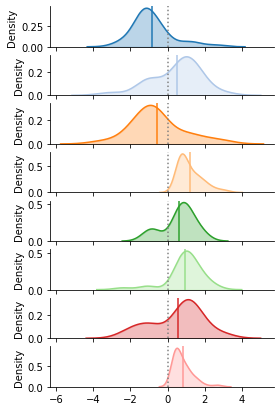

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

<Figure size 360x72 with 0 Axes>

In [7]:
# plot score distributions per cluster
g_names  = np.array(frame['description'][frame['is_gene']])

SCORES = np.array(scores.loc[g_names]['Ex'])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(4,7))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i]);
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)

    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)

fig.savefig(out_path+'_density.pdf')

#### plot clusters and names

/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/3759180721.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/3759180721.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


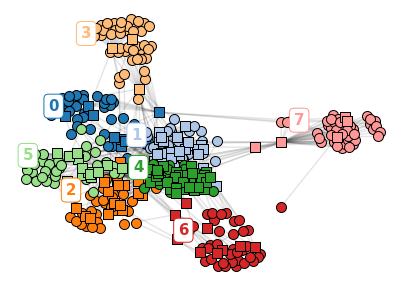

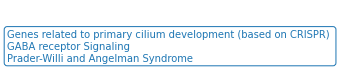

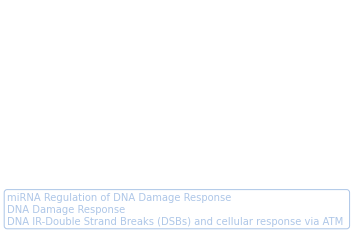

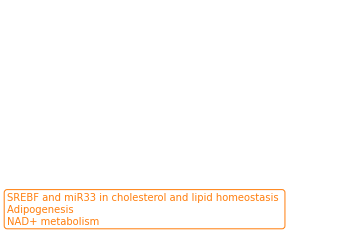

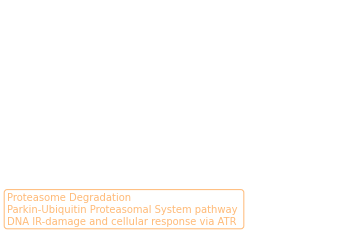

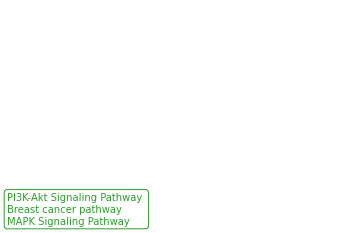

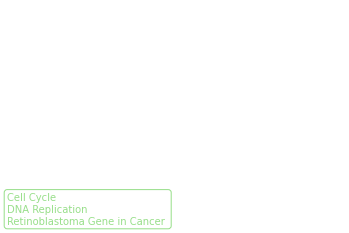

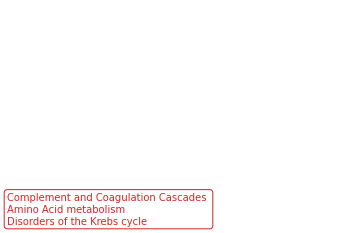

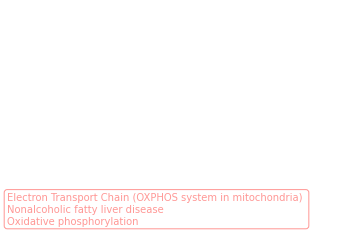

<Figure size 432x288 with 0 Axes>

In [8]:
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path, 3)

#### plot specific clusters

/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/2046815586.py:201: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/2046815586.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/2046815586.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')
/state/partition1/slurm_tmp/23725854.0.0/ipykernel_1078638/2046815586.py:201: MatplotlibDeprecation

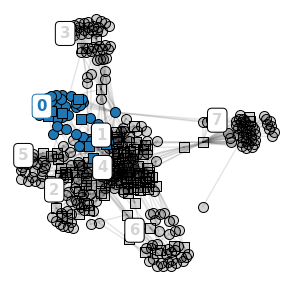

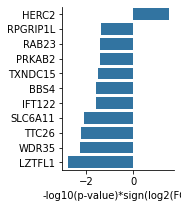

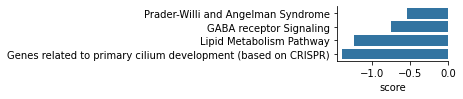

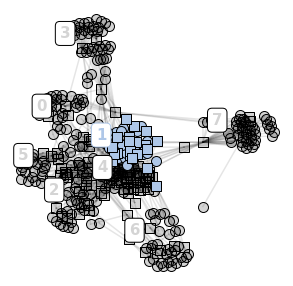

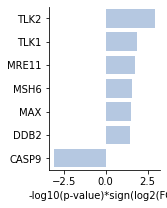

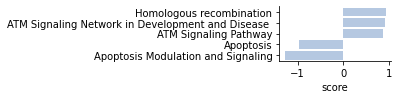

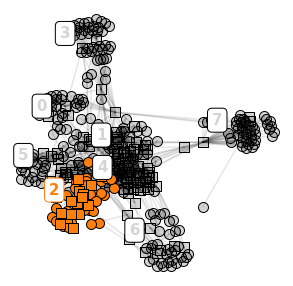

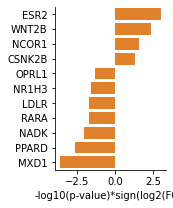

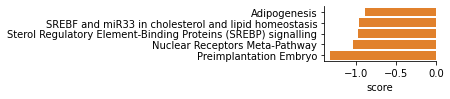

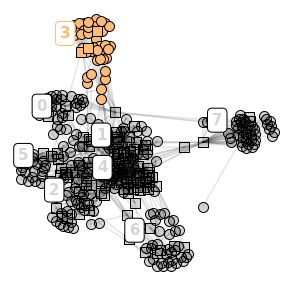

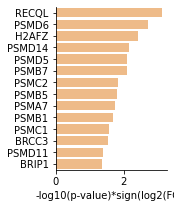

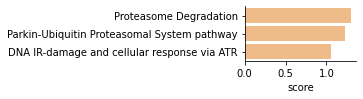

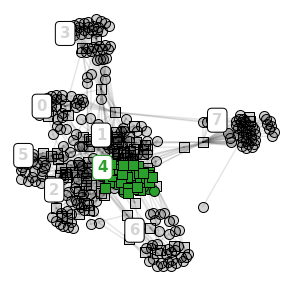

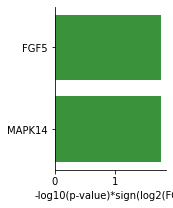

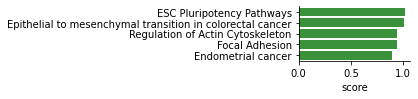

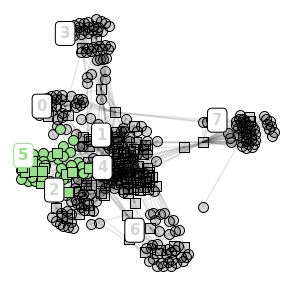

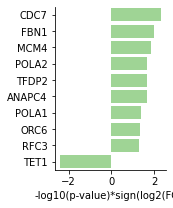

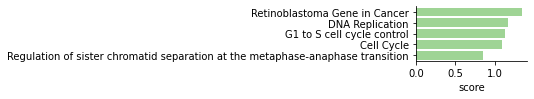

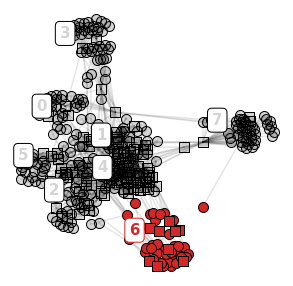

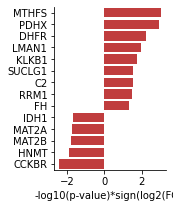

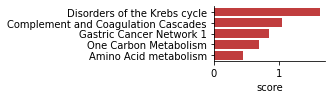

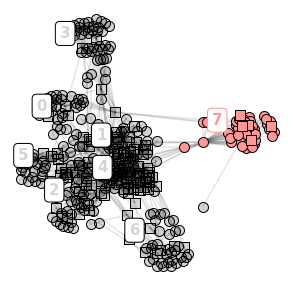

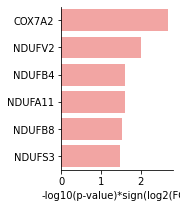

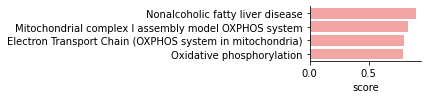

In [70]:
for i in unique_clusters:
    plot_sub_graph(i, frame, 'Ex', out_path, layout, graph, pos, cur_labels, scores, mat_sub, (5,5), (2,3), (2,1))

In [73]:
# save clusters to supp 
frame.to_csv('./supplementary_tables/data_s8.csv')